In [1]:
kaggle=False
kaggle_path=''
local_path='train.csv'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torchtext
import pandas as pd
import time
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [2]:
df=pd.read_csv(kaggle_path if kaggle else local_path)
df.sample(5)

,id,keyword,location,text,target
3716,5284,fear,NaN,I want to be with you forever\nStay by my side...,0
4956,7063,meltdown,#partsunknown,THE GLOBAL ECONOMIC MELTDOWN is out! http://t....,1
5085,7252,nuclear%20disaster,The Netherlands,?#FUKUSHIMA?#TEPCO?\nFukushima Nuclear Disaste...,1
2085,2995,dead,Spare 'Oom,that's it val is dead im suing,1
3931,5589,flood,NaN,Internet basics: the flood defective intertiss...,1


In [25]:
df.target.unique()

array([1, 0])

In [26]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Tokenizer-Funktion
def tokenizer(text):
    # use spacey for tokenization
    return [tok.text for tok in nlp.tokenizer(text)]

# Vokabular erstellen
def build_vocab(texts, vocab_size=None):
    word_to_idx = {}
    for text in texts:
        tokens = tokenizer(text)
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = len(word_to_idx)
                
    if vocab_size is not None:
        word_to_idx = {k: v for k, v in sorted(word_to_idx.items(), key=lambda item: item[1])[:vocab_size]}
    return word_to_idx
    
    
    
# Texte in Sequenzen von Wortindizes umwandeln
def text_to_indices(text, word_to_idx):
    tokens = tokenizer(text)
    indices = [word_to_idx[token] if token in word_to_idx else 0 for token in tokens]
    return indices

# Hyperparameter
vocab_size = None  # infinite vocab
word_count = 200
embedding_dim = 128
hidden_dim = 256
num_layers = 2
num_classes = 2
batch_size = 32

num_epochs = 2

# Aufteilung in Trainings- und Testdaten
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Erstellung des Vokabulars
texts = train_df['text'].tolist()
word_to_idx = build_vocab(texts)
vocab_size=len(word_to_idx)
print("vocab size:", vocab_size)

vocab size: 22877


In [27]:
def text_pipeline(x):                           
    return text_to_indices(x, word_to_idx)

text_pipeline("This is a test sentence")

[1636, 98, 24, 9216, 0]

In [31]:
class DisasterTweetsDataset(Dataset):
    def __init__(self, df, vocab_size=10000, test=False):
        self.df = df
        self.vocab_size = vocab_size
        self.test = test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x= self.df.iloc[idx]["text"]
        if not self.test:
            y= self.df.iloc[idx]["target"]
            y = int(y)
            y= torch.tensor(y, dtype=torch.long)
        x = text_pipeline(x)
        x = torch.tensor(x)
        if not self.test:
            return x, y
        return x
    
disaster_tweets_dataset = DisasterTweetsDataset(df, vocab_size=vocab_size)
x,y=disaster_tweets_dataset[2000]
print(x)
print(y)

tensor([12467,    44,  2349,    98,  4869,  6118,     1,   516,  2020,  2249,
          369, 16859,    69,    24, 20435,     1,  5155,    69, 20436,   119,
           24,  1272, 20437])
tensor(0)


In [32]:
def collate_batch(batch):
    x,y = zip(*batch)
    # collate for embedding bag
    offsets = [0] + [len(x_i) for x_i in x]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    x = torch.cat(x)
    y = torch.stack(y)
    return x, offsets, y

# test custom collate function
print("Tweet 0:'", df.iloc[0].text, "' |  target", df.iloc[0].target)
print("Tweet 1:'", df.iloc[1].text, "' |  target", df.iloc[1].target)
print(collate_batch([disaster_tweets_dataset[0], disaster_tweets_dataset[1]]))

Tweet 0:' Forest fire near La Ronge Sask. Canada ' |  target 1
Tweet 1:' Forest fire near La Ronge Sask. Canada ' |  target 1
(tensor([   71, 14891,   866,    44,  7906,     4,   110,    13,  2904,  2090,
            0,     0,   227,   343,   439,   495,   554,  2356, 17024, 17025,
           12,  8618]), tensor([ 0, 14]), tensor([1, 1]))


In [13]:

from torch import nn
import torch.nn.init as init

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)  # sparse means: 
        self.fc = nn.Linear(embed_dim, 30)
        self.dropout = nn.Dropout(0.5)
        self.fc2= nn.Linear(30, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        # uniform initialisation for the embedding layer
        self.embedding.weight.data.uniform_(-initrange, initrange)
        #self.fc.weight.data.uniform_(-initrange, initrange)
        #self.fc.bias.data.zero_()
        
        # He initialisation for the weights of the fully connected layer
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        out=self.fc(embedded)
        out=self.dropout(out)
        # relu
        out=nn.ReLU()(out)
        return self.fc2(out)
    
# test model
model = TextClassificationModel(vocab_size, embedding_dim, num_classes)
model(x, torch.tensor([0]))


tensor([[ 0.1460, -0.0646]], grad_fn=<AddmmBackward0>)

Initializing weights in a neural network, including an embedding layer like nn.EmbeddingBag in PyTorch, is a crucial step in preparing the model for training. The init_weights method in your TextClassificationModel class plays a significant role in this process. Here's why it's important:

* Breaking Symmetry: When a network starts with all weights having the same value, learning can be inefficient or even stall completely. Different initial weights allow for symmetry breaking, ensuring that different neurons can learn different functions.
* Improving Convergence: Proper initialization can speed up the convergence of the training process by starting the optimization closer to the optimal solution. Bad initialization can lead to slower convergence or getting stuck in suboptimal minima.
* Control of Variance: In deep networks, it's important to control the variance of activations and gradients as they pass through the layers. If the variance is too high, you might encounter exploding gradients; if it's too low, vanishing gradients can occur. Good initialization keeps the variance in a reasonable range.
* Embedding Specifics: For embedding layers, like nn.EmbeddingBag, initialization is particularly important because they map discrete input (like words) into continuous vectors. The initial values of these vectors can determine how effectively the model learns the relationships between different inputs. A uniform distribution, as used in your init_weights method, is a common choice. It assigns a wide range of different values to the embedding weights, encouraging the model to explore a diverse set of representations.
* Sparse Embeddings: You're using a sparse embedding (sparse=True), which is often used for memory efficiency with large vocabularies. Sparse embeddings can have different optimization dynamics compared to dense embeddings, and initializing them properly can be even more crucial to ensure that the sparse gradients are effective in updating the weights.
* Consistency and Reproducibility: By initializing weights in a controlled manner (like using a fixed range in your case), you can have more consistent results across different runs, which is important for debugging and comparing different models.

In [14]:
# test all together
df_to_test=df.sample(10)
dataset_to_test = DisasterTweetsDataset(df_to_test, vocab_size=vocab_size)
dataloader_to_test = DataLoader(dataset_to_test, batch_size=4, shuffle=True, collate_fn=collate_batch)
for x, offsets, y in dataloader_to_test:
    print("x: ", x)
    print("offsets: ", offsets)
    print("y: ", y)
    print("model output: " , model(x, offsets))
    print("End Batch\n\n\n")

x:  tensor([    0,  6287,    54,    54,   235,  2349,   962,   847,   313,  3593,
          300,   140, 10264,     0,     0,   460,  3369,   322,     0,  1521,
          614, 16361,   132,     0,   619,     0,     0,  6511,   751,  6512,
         6513,    43,    44,  6514,   305,   516,   322,  1027,  6515,   432,
          751,   751,  1318,  6516,  1692,  6517,   137,   132,   486,   101,
         2392,  4794,  1339,    10,    44,  2258,   409,    44,  2065])
offsets:  tensor([ 0, 11, 27, 46])
y:  tensor([0, 0, 0, 1])
model output:  tensor([[-0.1135,  0.0624],
        [-0.0550,  0.0823],
        [ 0.0027, -0.0408],
        [-0.0350, -0.0073]], grad_fn=<AddmmBackward0>)
End Batch



x:  tensor([   0,   24,  364, 5792,   67,   38,  681,   38,    0,    0, 1330,    1,
        4168,  235, 3941,  343,   92, 1252,   10, 4356,   41,  156, 7306, 5833,
        1418, 1419, 7307,   13, 7308,   13, 2563, 4557,  212, 1253, 2937,   10,
        5626,   67,  546, 4944,  119, 2603, 1251,   24, 5627, 4

In [15]:
def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, (x, offsets, y) in enumerate(dataloader):
            predicted_label = model(x, offsets)
            total_acc += (predicted_label.argmax(1) == y).sum().item()
            total_count += y.size(0)
    return total_acc/total_count

-----------------------------------------------------------
| end of epoch   1 | time:  1.28s | train accuracy    0.626 | valid accuracy    0.637 | lr: 1.00
-----------------------------------------------------------
| end of epoch   2 | time:  1.19s | train accuracy    0.708 | valid accuracy    0.672 | lr: 1.00
-----------------------------------------------------------
| end of epoch   3 | time:  1.14s | train accuracy    0.710 | valid accuracy    0.716 | lr: 1.00
-----------------------------------------------------------
| end of epoch   4 | time:  1.18s | train accuracy    0.734 | valid accuracy    0.719 | lr: 0.90
-----------------------------------------------------------
| end of epoch   5 | time:  1.14s | train accuracy    0.610 | valid accuracy    0.601 | lr: 0.90
-----------------------------------------------------------
| end of epoch   6 | time:  1.18s | train accuracy    0.786 | valid accuracy    0.745 | lr: 0.90
----------------------------------------------------------

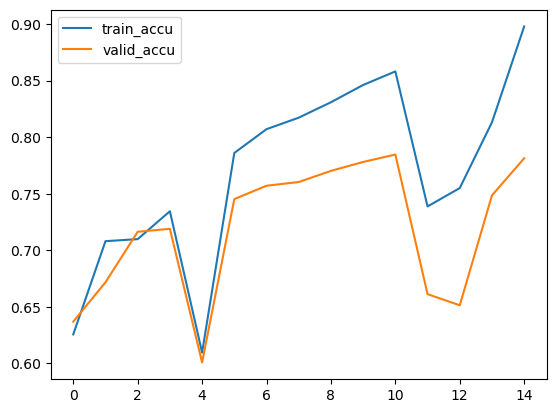

In [16]:
# Hyperparameters
EPOCHS = 15 # epoch
LR = 1  # learning rate
BATCH_SIZE = 64 # batch size for training
embedding_dim = 128
num_classes = 2


model = TextClassificationModel(vocab_size, embedding_dim, num_classes)

train_dataset=DisasterTweetsDataset(train_df, vocab_size=vocab_size)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataset=DisasterTweetsDataset(test_df, vocab_size=vocab_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

loss_func = torch.nn.CrossEntropyLoss()
#
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3.0, gamma=0.9)   # every 3 epochs, LR is multiplied by 0.7
total_accu = None

train_accus=[]
valid_accus=[]


for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    model.train()
    total_acc, total_count = 0, 0

    for idx, (x, offsets, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
       
        predicted_label = model(x, offsets)
        loss = loss_func(predicted_label, y)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

    accu_train = evaluate(model, train_dataloader)
    accu_valid = evaluate(model, valid_dataloader)
    train_accus.append(accu_train)
    valid_accus.append(accu_valid)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train accuracy {:8.3f} | valid accuracy {:8.3f} | lr: {:1.2f}'.format(
                                epoch,
                                time.time() - epoch_start_time,
                                accu_train, 
                                accu_valid, 
                                scheduler.get_last_lr()[0]))

    scheduler.step() # learning rate scheduler after each epoch



import matplotlib.pyplot as plt
plt.plot(train_accus, label='train_accu')
plt.plot(valid_accus, label='valid_accu')
plt.legend()
plt.show()

In [17]:
local_test_path='test.csv'
kaggle_test_path=''

df_submission_test_data=pd.read_csv(kaggle_test_path if kaggle else local_test_path)
df_submission_test_data.sample(5)


,id,keyword,location,text
3004,9926,trouble,Lansing ?? Ypsilanti,Must black folks don't wanna stir up trouble ....
2935,9721,tragedy,http://www.amazon.com/dp/B00HR,'1 Death is a tragedy; a million Deaths is a s...
2276,7597,pandemonium,LND Greatest City In the World,What scenes at Trent Bridge England could win ...
1667,5623,flooding,NaN,Awh damn I just realized yall gone flooding m...
434,1404,body%20bag,Dalton,http://t.co/3d2h2wOQwa NEW! DIESEL WILLYT Prin...


In [18]:
def collate_batch_test_data(batch):
    x = batch
    # collate for embedding bag
    offsets = [0] + [len(x_i) for x_i in x]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    x = torch.cat(x)
    return x, offsets

In [19]:
model.eval()
preds=[]
test_dataset=DisasterTweetsDataset(df_submission_test_data, vocab_size=vocab_size, test=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch_test_data)
with torch.no_grad():
    for idx, (x, offsets) in enumerate(test_dataloader):
        predicted_label = model(x, offsets)
        preds.extend(predicted_label.argmax(1).tolist())

df_submission_test_data["target"]=preds
df_submission_test_data[["id", "target"]].to_csv("submission.csv", index=False)

In [20]:
# Score: 0.65675